In [1]:
from client.api.notebook import Notebook
ok = Notebook('proj1.ok')

Assignment: proj1
OK, version v1.18.1



# Project 1: Spam/Ham Classification
## Due Date: Friday 5/21, 11:59 PM

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about
the project, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your notebook.

**Collaborators**: *list collaborators here*

## This Assignment
In this project, you will use what you've learned in class to create a classifier that can distinguish spam (junk or commercial or bulk) emails from ham (non-spam) emails. In addition to providing some skeleton code to fill in, we will evaluate your work based on your model's accuracy and your written responses in this notebook.

After this project, you should feel comfortable with the following:

- Feature engineering with text data
- Using sklearn libraries to process data and fit models
- Validating the performance of your model and minimizing overfitting
- Generating and analyzing precision-recall curves

## <span style="color:red">Warning</span> 
We've tried our best to filter the data for anything blatantly offensive as best as we can, but unfortunately there may still be some examples you may find in poor taste. If you encounter these examples and believe it is inappropriate for students, please let a TA know and we will try to remove it for future semesters. Thanks for your understanding!

## Score Breakdown
Question | Points
--- | ---
1a | 1
1b | 1
1c | 2
2 | 3
3 | 2
4 | 2
5 | 2
6a | 1
6b | 1
6c | 2
6d | 2
6e | 2
7 | 6
8 | 6
9 | 6
10 | 6
Total | 45

# Part I - Initial Analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### Loading in the Data

In email classification, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset consists of email messages and their labels (0 for ham, 1 for spam). Your labeled training dataset contains 8348 labeled examples, and the test set contains 1000 unlabeled examples.

Run the following cells to load in the data into DataFrames.

The `train` DataFrame contains labeled data that you will use to train your model. It contains four columns:

1. `id`: An identifier for the training example
1. `subject`: The subject of the email
1. `email`: The text of the email
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)

The `test` DataFrame contains 1000 unlabeled emails. You will predict labels for these emails and submit your predictions to Kaggle for evaluation.

In [3]:
original_training_data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

### Question 1a
First, let's check if our data contains any missing values. 

- Fill in the cell below to print the number of NaN values in each column.
- If there are NaN values, replace them with appropriate filler values (i.e., NaN values in the `subject` or `email` columns should be replaced with empty strings). 
- Print the number of NaN values in each column after this modification to verify that there are no NaN values left.

Note that while there are no NaN values in the `spam` column, we should be careful when replacing NaN labels. Doing so without consideration may introduce significant bias into our model when fitting.

*The provided test checks that there are no missing values in your dataset.*

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [4]:
# BEGIN YOUR CODE
# -----------------------
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')   # 빈 문자로 채우기
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())
# -----------------------
# END YOUR CODE

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


In [5]:
ok.grade("q1a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

### Question 1b

In the cell below, print the text of the first ham and the first spam email in the original training set.

*The provided tests just ensure that you have assigned `first_ham` and `first_spam` to rows in the data, but only the hidden tests check that you selected the correct observations.*

<!--
BEGIN QUESTION
name: q1b
points: 1
-->

In [6]:
# BEGIN YOUR CODE
# -----------------------
first_ham = original_training_data.loc[original_training_data['spam'] == 0, 'email'].iloc[0]
first_spam = original_training_data.loc[original_training_data['spam'] == 1, 'email'].iloc[0]
# -----------------------
# END YOUR CODE

print('The text of the first Ham:')
print('------------')
print(first_ham)

print('The text of the first Spam:')
print('------------')
print(first_spam)

The text of the first Ham:
------------
url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

The text of the first Spam:
------------
<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



In [7]:
ok.grade("q1b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

### Question 1c

Discuss one thing you notice that is different between the two emails that might relate to the identification of spam.

<!--
BEGIN QUESTION
name: q1c
manual: True
points: 2
-->
<!-- EXPORT TO PDF -->

Answer: `스팸 메일은 'http://209.163.187.47'로 시작하는 링크가 걸려있다. 반면 스팸이 아닌 일반 메일은 그냥 평범한 링크 주소가 적혀있다. 또 확인해본 대부분의 스팸 메일은 html형식으로 이루어져있다. 또한 spam메일에 비교적 html 언어가 많이 들어있는 듯 하다.`

## Training Validation Split
The training data we downloaded is all the data we have available for both training models and **validating** the models that we train.  We therefore need to split the training data into separate training and validation datsets.  You will need this **validation data** to assess the performance of your classifier once you are finished training. 

Note that we set the seed (random_state) to 42. This will produce a pseudo-random sequence of random numbers that is the same for every student. **Do not modify this in the following questions, as our tests depend on this random seed.**

In [8]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size=0.1, random_state=42)

# Basic Feature Engineering

We would like to take the text of an email and predict whether the email is **ham** or **spam**. This is a *classification* problem, and here we use logistic regression to train a classifier. 

Recall that to train an logistic regression model we need:
 - a numeric feature matrix $X$
 - a vector of corresponding binary labels $y$.

Unfortunately, our data are text, not numbers. To address this, we can create numeric features derived from the email text and use those features for logistic regression:
 - Each row of $X$ is an email.
 - Each column of $X$ contains one feature for all the emails. 
 
We'll guide you through creating a simple feature, and you'll create more interesting ones when you are trying to increase your accuracy.

<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

### Question 2

Create a function called `words_in_texts` that takes in a list of `words` and a pandas Series of email `texts`. It should output a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. For example:

```
>>> words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])
```

**Hint**: [pandas.Series.str.contains](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.contains.html)

*The provided tests make sure that your function works correctly, so that you can use it for future questions.*

<!--
BEGIN QUESTION
name: q2
points: 3
-->

In [9]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    # BEGIN YOUR CODE
    # -----------------------
    indicator_df = pd.DataFrame([])
    for w in words:
        indicator_df[w] = texts.str.contains(w)
        
    indicator_array = indicator_df.astype(int).values
    # -----------------------
    # END YOUR CODE
    
    return indicator_array

In [10]:
words_in_texts(['hello', 'bye', 'world'], pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])

In [11]:
ok.grade("q2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



# Basic EDA

We need to identify some features that allow us to distinguish spam emails from ham emails. One idea is to compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. 

If the feature is itself a binary indicator (such as whether a certain word occurs in the text), this amounts to comparing the proportion of spam emails with the word to the proportion of ham emails with the word.

The following plot (which was created using `sns.barplot`) compares the proportion of emails in each class containing a particular set of words. 

![training conditional proportions](./images/training_conditional_proportions.png "Class Conditional Proportions")

In [12]:
from IPython.display import display, Markdown
df = pd.DataFrame({
    'word_1': [1, 0, 1, 0],
    'word_2': [0, 1, 0, 1],
    'type': ['spam', 'ham', 'ham', 'ham']
})
display(Markdown("> Our Original DataFrame has some words column and a type column. You can think of each row is a sentence, and the value of 1 or 0 indicates the number of occurances of the word in this sentence."))
display(df);
display(Markdown("> `melt` will turn columns into variale, notice how `word_1` and `word_2` become `variable`, their values are stoed in the value column"))
display(df.melt("type"))

> Our Original DataFrame has some words column and a type column. You can think of each row is a sentence, and the value of 1 or 0 indicates the number of occurances of the word in this sentence.

,word_1,word_2,type
0,1,0,spam
1,0,1,ham
2,1,0,ham
3,0,1,ham


> `melt` will turn columns into variale, notice how `word_1` and `word_2` become `variable`, their values are stoed in the value column

,type,variable,value
0,spam,word_1,1
1,ham,word_1,0
2,ham,word_1,1
3,ham,word_1,0
4,spam,word_2,0
5,ham,word_2,1
6,ham,word_2,0
7,ham,word_2,1


We can create a bar chart like the one above comparing the proportion of spam and ham emails containing certain words. Choose a set of words that are different from the ones above, but also have different proportions for the two classes. Make sure that we only consider emails from `train`.

<!--
BEGIN QUESTION
name: q3a
manual: True
format: image
points: 2
-->
<!-- EXPORT TO PDF format:image -->

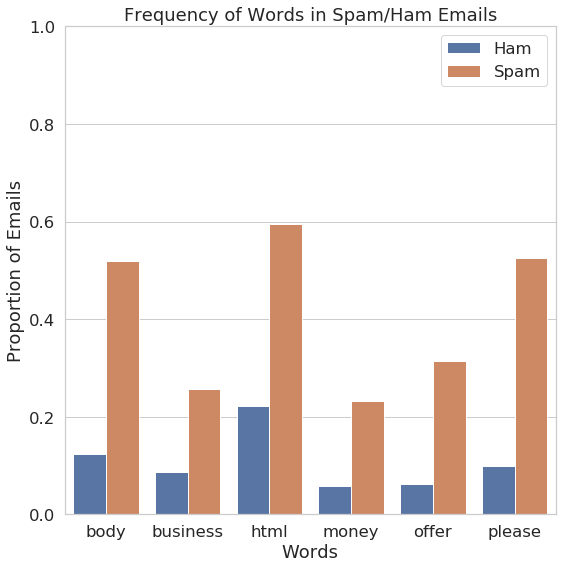

In [13]:
# We must do this in order to preserve the ordering of emails to labels for words_in_texts
train=train.reset_index(drop=True) 

some_words = ['body', 'html', 'please', 'money', 'business', 'offer']
Phi_train = words_in_texts(some_words, train['email'])

df = pd.DataFrame(data = Phi_train, columns = some_words)
df['label'] = train['spam']

plt.figure(figsize=(8,8))
sns.barplot(x = "variable", 
            y = "value", 
            hue = "label", 
            data = (df
                    .replace({'label': 
                                {0 : 'Ham', 
                                 1 : 'Spam'}})
                    .melt('label')
                    .groupby(['label', 'variable'])
                    .mean()
                    .reset_index()))

plt.ylim([0, 1])
plt.xlabel('Words')
plt.ylabel('Proportion of Emails')
plt.legend(title = "")
plt.title("Frequency of Words in Spam/Ham Emails")
plt.tight_layout()
plt.show()

<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

### Question 3

When the feature is binary, it makes sense to compare its proportions across classes (as in the previous question). Otherwise, if the feature can take on numeric values, we can compare the distributions of these values for different classes. 

![training conditional densities](./images/training_conditional_densities2.png "Class Conditional Densities")

Create a *class conditional density plot* like the one above (using `sns.distplot`), comparing the distribution of the length of spam emails to the distribution of the length of ham emails in the training set. Set the x-axis limit from 0 to 50000.

<!--
BEGIN QUESTION
name: q3b
manual: True
format: image
points: 2
-->
<!-- EXPORT TO PDF format:image -->

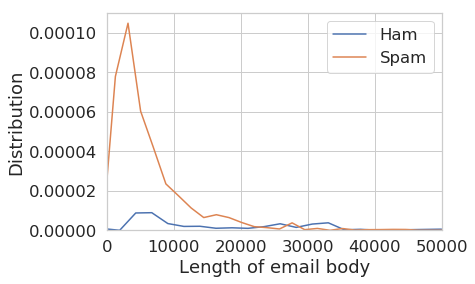

In [14]:
# BEGIN YOUR CODE
# -----------------------
ham_len = train.loc[train['spam'] == 0, 'email'].str.len()
spam_len = train.loc[train['spam'] == 1, 'email'].str.len()

sns.distplot(ham_len, hist=False, label='Ham')
sns.distplot(spam_len, hist=False, label='Spam')

plt.xlim(0, 50000)
plt.xlabel("Length of email body")
plt.ylabel("Distribution")
plt.legend()
# -----------------------
# END YOUR CODE

## Basic Classification

Notice that the output of `words_in_texts(words, train['email'])` is a numeric matrix containing features for each email. This means we can use it directly to train a classifier!

<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

### Question 4

We've given you 5 words that might be useful as features to distinguish spam/ham emails. Use these words as well as the `train` DataFrame to create two NumPy arrays: `X_train` and `Y_train`.

- `X_train` should be a matrix of 0s and 1s created by using your `words_in_texts` function on all the emails in the training set.

- `Y_train` should be a vector of the correct labels for each email in the training set.

*The provided tests check that the dimensions of your feature matrix (X) are correct, and that your features and labels are binary (i.e. consists of 0 and 1, no other values). It does not check that your function is correct; that was verified in a previous question.*

<!--
BEGIN QUESTION
name: q4
points: 2
-->

In [15]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

# BEGIN YOUR CODE
# -----------------------
X_train = words_in_texts(some_words, train['email'])   # email에 주어진 단어들이 등장했는지 여부
Y_train = np.array(train['spam'])
# -----------------------
# END YOUR CODE

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]), array([0, 0, 0, 0, 0]))

In [16]:
ok.grade("q4");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

### Question 5

Now we have matrices we can give to scikit-learn! 

- Using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, train a logistic regression model using `X_train` and `Y_train`.
- Then, output the accuracy of the model (on the training data) in the cell below. You should get an accuracy around 0.75.

*The provided test checks that you initialized your logistic regression model correctly.*

<!--
BEGIN QUESTION
name: q5
points: 2
-->

In [17]:
from sklearn.linear_model import LogisticRegression

# BEGIN YOUR CODE
# -----------------------
model = LogisticRegression().fit(X_train, Y_train)
training_accuracy = model.score(X_train, Y_train)
# -----------------------
# END YOUR CODE

print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.757620125116


In [18]:
ok.grade("q5");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



## Evaluating Classifiers

That doesn't seem too shabby! But the classifier you made above isn't as good as this might lead us to believe. First, we are evaluating accuracy on the training set, which may lead to a misleading accuracy measure, especially if we used the training set to identify discriminative features. In future parts of this analysis, it will be safer to hold out some of our data for model validation and comparison.

Presumably, our classifier will be used for **filtering**, i.e. preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- False positive (FP): a ham email gets flagged as spam and filtered out of the inbox.
- False negative (FN): a spam email gets mislabeled as ham and ends up in the inbox.

These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of spam emails that were correctly flagged as spam. 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam. 

The following image might help:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" width="500px">

Note that a true positive (TP) is a spam email that is classified as spam, and a true negative (TN) is a ham email that is classified as ham.

<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

### Question 6a

Suppose we have a classifier `zero_predictor` that always predicts 0 (never predicts positive). How many false positives and false negatives would this classifier have if it were evaluated on the training set and its results were compared to `Y_train`? Fill in the variables below (answers can be hard-coded):

*Tests in Question 6 only check that you have assigned appropriate types of values to each response variable, but do not check that your answers are correct.*

<!--
BEGIN QUESTION
name: q6a
points: 1
-->

In [19]:
# BEGIN YOUR CODE
# -----------------------
zero_predictor_fp = 0
zero_predictor_fn = len(train[train['spam']==1])
# -----------------------
# END YOUR CODE

In [20]:
ok.grade("q6a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

### Question 6b

What are the accuracy and recall of `zero_predictor` (classifies every email as ham) on the training set? Do NOT use any `sklearn` functions.

<!--
BEGIN QUESTION
name: q6b
points: 1
-->

In [21]:
# BEGIN YOUR CODE
# -----------------------
zero_predictor_acc = len(train[train['spam']==0]) / len(train)
zero_predictor_recall = 0 / (0 + zero_predictor_fn)
# -----------------------
# END YOUR CODE

In [22]:
print('zero_predictor_acc:', zero_predictor_acc)
print('zero_predictor_recall:', zero_predictor_recall)

zero_predictor_acc: 0.7447091707706642
zero_predictor_recall: 0.0


In [23]:
ok.grade("q6b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

### Question 6c

Provide brief explanations of the results from 6a and 6b. Why do we observe each of these values (FP, FN, accuracy, recall)?

<!--
BEGIN QUESTION
name: q6c
manual: True
points: 2
-->
<!-- EXPORT TO PDF -->

Answer:   
zero_predictor_fp는 zero_predictor가 실제는 negative인 것을 positive라고 예측한 것의 갯수를 의미한다. zero_predictor_fn은 zero_predictor가 실제는 positive인 것을 negative라고 예측한 것을 말한다. 6a, 6b의 모델은 zero_predictor 모델로 모든 것을 negative라고 예측한다. 모든 것을 negative라고 예측하기 때문에 positive라고 예측한 것이 없어서 zero_predictor_fp는 0이 된다. 반면 모든 것을 negative라고 예측하기 때문에 zero_predictor_fn은 positive의 갯수가 된다. accuray는 전체 중에서 제대로 예측한 것의 비율이다. (tp+tn)/all 인데, tp는 positive로 예측한 것이 없기 때문에 0이 된다. 따라서 zero_predictor의 accuray는 (negative 갯수)/(전체갯수)가 된다. recall은 (positive인 것을 positive로 예측한 갯수) / (positive 갯수)로 tp / (tp+fn)이 된다. 하지만 zero_predictor는 positive로 예측하는 것이 없으므로 tp = 0이 된다. 따라서 recall은 0이 된다.

<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

### Question 6d

Compute the precision, recall, and false-alarm rate of the `LogisticRegression` classifier created and trained in Question 5. **Note: Do NOT use any `sklearn` functions.**

<!--
BEGIN QUESTION
name: q6d
points: 2
-->

In [24]:
# BEGIN YOUR CODE
# -----------------------
Y_predict = model.predict(X_train)
tp, tn, fp, fn = 0, 0, 0, 0
for i in range(len(Y_train)):
    if Y_train[i] == Y_predict[i]:
        if Y_train[i] == 1:
            tp += 1
        elif Y_train[i] == 0:
            tn += 1
    elif Y_train[i] != Y_predict[i]:
        if Y_train[i] == 1:
            fn += 1
        elif Y_train[i] == 0:
            fp += 1
        
        
logistic_predictor_precision = tp / (tp+fp) # tp/(tp+fp)   # positive라고 판별한 것 중 실제 positive인 것
logistic_predictor_recall = tp / (tp+fn) # tp/(tp+fn)   # 실제로 positive인 것 중에 positive라고 판별한 것
logistic_predictor_far = 1 - logistic_predictor_precision # 1 - precision   # positive라고 판별한 것 중 실제 negative
# -----------------------
# END YOUR CODE

In [25]:
print('logistic_predictor_precision:', logistic_predictor_precision)
print('logistic_predictor_recall:', logistic_predictor_recall)
print('logistic_predictor_far:', logistic_predictor_far)

logistic_predictor_precision: 0.6422287390029325
logistic_predictor_recall: 0.11418143899895725
logistic_predictor_far: 0.35777126099706746


In [26]:
ok.grade("q6d");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

### Question 6e

1. Our logistic regression classifier got 75.6% prediction accuracy (number of correct predictions / total). How does this compare with predicting 0 for every email?
1. Given the word features we gave you above, name one reason this classifier is performing poorly. Hint: Think about how prevalent these words are in the email set.
1. Which of these two classifiers would you prefer for a spam filter and why? Describe your reasoning and relate it to at least one of the evaluation metrics you have computed so far.

<!--
BEGIN QUESTION
name: q6f
manual: True
points: 3
-->
<!-- EXPORT TO PDF -->

Answer:
1. zero_predictor의 accuracy는 74.47091707706642%이다. 이는 우리의 logistic regression classifier의 accuaracy인 75.6%보다 낮다.
2. spam과 ham별로 주어진 단어의 빈도를 그래프로 그려보면, memo라는 단어는 ham메일과 spam메일에서 비슷하게 등장하는 것을 알 수 있다. 이 때문에 classifier가 poorly하게 perfoming 한다고 볼 수 있다.
3. zero_predictor는 모든 메일은 negative로 판별하기 때문에 recall이 0이다. 이는 필터링이 전혀 되지 않는것을 의미한다. 또한 zero_predictor보다 logistic regression classifier의 accuray가 더 높다. 따라서 spam 메일을 거르고 싶다면 accuracy가 더 높고 recall이 0이 아닌 logistic regression classifier가 더 적합할 것 같다. 단, 이는 false-alram rate이 0이 아니므로 스팸이 아닌 메일이 스팸이라고 판별될 수도 있다. 만약, 스팸이 아닌 메일이 스팸 처리 되지 않는 것이 더 중요하다면 zero_predictor를 사용하는것이 나을 것이다. 이는 모든 것을 negative라고 판별하므로, 스팸이 아닌 메일을 스팸이라고 판별하지는 않을 것이다. 따라서 어떤 것을 더 중요하게 여기는지에 따라 사용하면 될 것 같다. 개인적으로는 spam을 거르기 위해 classifier를 사용하는 것이라면 스팸이 아닌 스팸이라고 처리될 수는 있겠지만, zero_predictor는 spam처리를 전혀 하지 않기 때문에 logistic regression classifier를 사용할 것이다.

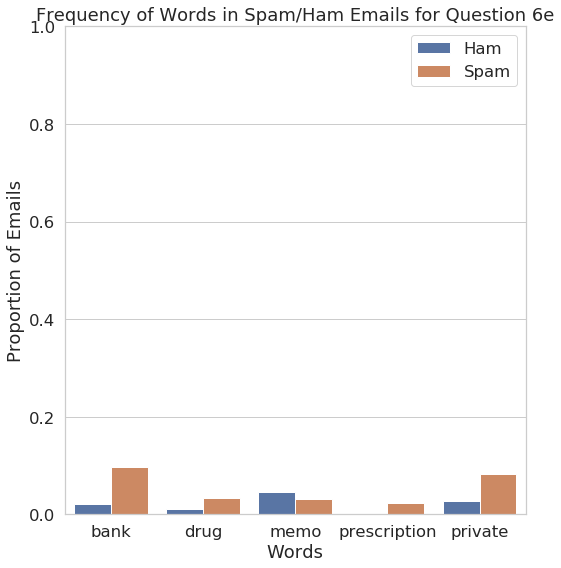

In [27]:
# 내가 임의로 만든것 for 6e
temp_train = words_in_texts(some_words, train['email'])

df = pd.DataFrame(data = temp_train, columns = some_words)
df['label'] = train['spam']
plt.figure(figsize=(8,8))
sns.barplot(x = "variable", 
            y = "value", 
            hue = "label", 
            data = (df
                    .replace({'label': 
                                {0 : 'Ham', 
                                 1 : 'Spam'}})
                    .melt('label')
                    .groupby(['label', 'variable'])
                    .mean()
                    .reset_index()))

plt.ylim([0, 1])
plt.xlabel('Words')
plt.ylabel('Proportion of Emails')
plt.legend(title = "")
plt.title("Frequency of Words in Spam/Ham Emails for Question 6e")
plt.tight_layout()
plt.show()

# Part II - Moving Forward

With this in mind, it is now your task to make the spam filter more accurate. In order to get full credit on the accuracy part of this assignment, you must get at least **77%** accuracy on the test set. To see your accuracy on the test set, you will use your classifier to predict every email in the `test` DataFrame and upload your predictions to Kaggle.

Here are some ideas for improving your model:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject / body
    1. Number of words in the subject / body
    1. Use of punctuation (e.g., how many '!' were there?)
    1. Number / percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. 
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting out the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust parameters of your model (e.g. the regularization parameter) to achieve higher accuracy. Recall that you should use cross-validation to do feature and model selection properly! Otherwise, you will likely overfit to your training data.

ou may use whatever method you prefer in order to create features, but **you are not allowed to import any external feature extraction libraries**. In addition, **you are only allowed to train logistic regression models**. No random forests, k-nearest-neighbors, neural nets, etc.

We have not provided any code to do this, so feel free to create as many cells as you need in order to tackle this task. However, answering questions 7, 8, and 9 should help guide you.

---

**Note:** *You should use the **validation data** to evaluate your model and get a better sense of how it will perform on the Kaggle evaluation.*

---

### 메일 제목/본문 길이, 단어 갯수

#### 메일의 제목 길이

In [28]:
ham_sub_len = train.loc[train['spam']==0, 'subject'].str.len()
spam_sub_len = train.loc[train['spam']==1, 'subject'].str.len()

Text(0,0.5,'Ditribution')

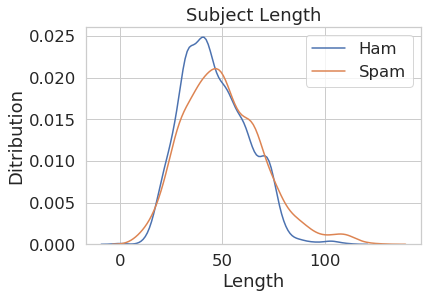

In [29]:
sns.distplot(ham_sub_len, hist=False, label='Ham')
sns.distplot(spam_sub_len, hist=False, label='Spam')

plt.title('Subject Length')
plt.xlabel('Length')
plt.ylabel('Ditribution')

#### 메일 제목 단어 수

In [30]:
ham_sub_num = train.loc[train['spam']==0, 'subject'].str.split().str.len()
spam_sub_num = train.loc[train['spam']==1, 'subject'].str.split().str.len()

Text(0,0.5,'Ditribution')

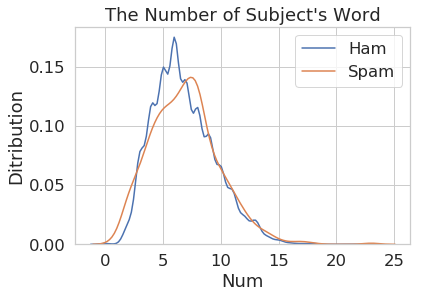

In [31]:
sns.distplot(ham_sub_num, hist=False, label='Ham')
sns.distplot(spam_sub_num, hist=False, label='Spam')

plt.title('The Number of Subject\'s Word')
plt.xlabel('Num')
plt.ylabel('Ditribution')

#### 메일 단어 수

In [32]:
ham_email_num = train.loc[train['spam']==0, 'email'].str.split().str.len()
spam_email_num = train.loc[train['spam']==1, 'email'].str.split().str.len()

(0, 2000)

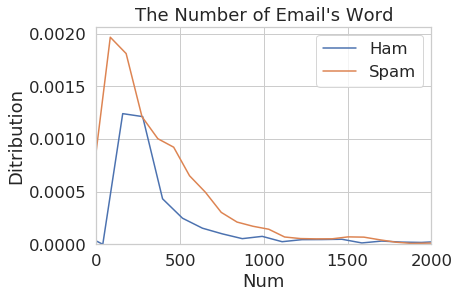

In [33]:
sns.distplot(ham_email_num, hist=False, label='Ham')
sns.distplot(spam_email_num, hist=False, label='Spam')

plt.title('The Number of Email\'s Word')
plt.xlabel('Num')
plt.ylabel('Ditribution')

plt.xlim(0, 2000)

#### 불용어를 제거한 메일 단어 수

In [34]:
stopwords = ['i', 'me', "my", "myself", 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'herself',
"it", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were',
'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over',
'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such',
'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']

In [35]:
def remove_stopwords(data):
    data = data.split()
    result = []
    for w in data: 
        if w not in stopwords: 
            result.append(w) 
    
    return result

In [36]:
ham_temp = train.loc[train['spam']==0, 'email'].map(remove_stopwords)
ham_temp2 = train.loc[train['spam']==1, 'email'].map(remove_stopwords)

(0, 4000)

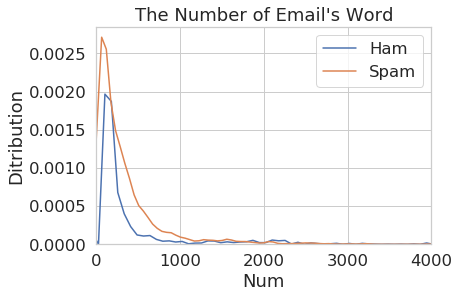

In [37]:
sns.distplot(ham_temp.str.len(), hist=False, label='Ham')
sns.distplot(ham_temp2.str.len(), hist=False, label='Spam')

plt.title('The Number of Email\'s Word')
plt.xlabel('Num')
plt.ylabel('Ditribution')

plt.xlim(0, 4000)

### 문장 부호 갯수

#### .,공백 문자 같은 것도 포함한 문장 부호 갯수

In [38]:
ham_puc = train.loc[train['spam']==0, 'email'].str.replace('[\w]', '').str.len()
spam_puc = train.loc[train['spam']==1, 'email'].str.replace('[\w]', '').str.len()

In [39]:
ham_puc.describe()

count      5595.000000
mean        946.980340
std        4102.503017
min          16.000000
25%         147.000000
50%         293.000000
75%         532.500000
max      177005.000000
Name: email, dtype: float64

In [40]:
spam_puc.describe()

count     1918.000000
mean      1583.291449
std       2087.852601
min         10.000000
25%        303.000000
50%        701.500000
75%       2061.250000
max      18516.000000
Name: email, dtype: float64

Text(0,0.5,'Ditribution')

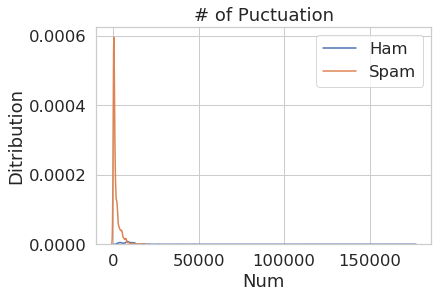

In [41]:
sns.distplot(ham_puc, hist=False, label='Ham')
sns.distplot(spam_puc, hist=False, label='Spam')

plt.title('# of Puctuation')
plt.xlabel('Num')
plt.ylabel('Ditribution')


#### .,공백 문자 포함 안 한 문장 부호 갯수

In [42]:
ham_puc2 = train.loc[train['spam']==0, 'email'].str.replace('[\w\s\.,]', '').str.len()
spam_puc2 = train.loc[train['spam']==1, 'email'].str.replace('[\w\s\.,]', '').str.len()

In [43]:
ham_puc2.describe()

count      5595.000000
mean        377.105273
std        3370.993071
min           0.000000
25%          26.000000
50%          52.000000
75%         126.000000
max      169133.000000
Name: email, dtype: float64

In [44]:
spam_puc2.describe()

count     1918.00000
mean       597.21220
std        877.72145
min          0.00000
25%         59.25000
50%        261.00000
75%        815.75000
max      10033.00000
Name: email, dtype: float64

Text(0,0.5,'Ditribution')

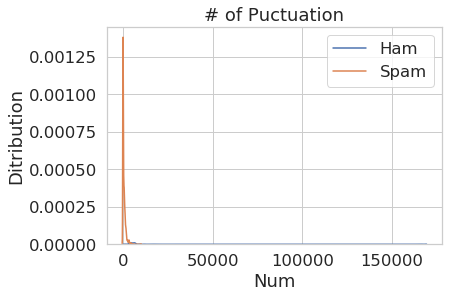

In [45]:
sns.distplot(ham_puc2, hist=False, label='Ham')
sns.distplot(spam_puc2, hist=False, label='Spam')

plt.title('# of Puctuation')
plt.xlabel('Num')
plt.ylabel('Ditribution')

#### ! 갯수

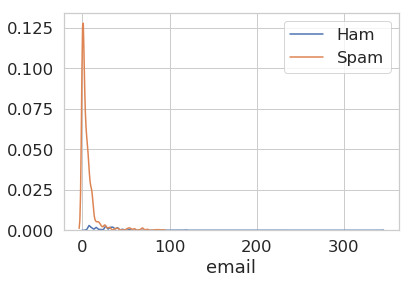

In [46]:
ham_exc = train.loc[train['spam']==0, 'email'].str.replace('[^!]', '').str.len()
spam_exc = train.loc[train['spam']==1, 'email'].str.replace('[^!]','').str.len()

sns.distplot(ham_exc, hist=False, label='Ham')
sns.distplot(spam_exc, hist=False, label='Spam')

#### ? 갯수

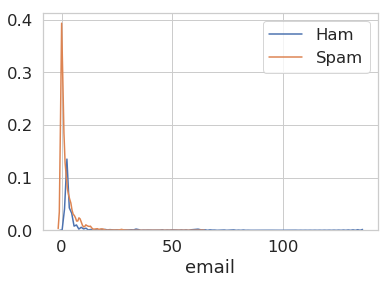

In [47]:
ham_qe = train.loc[train['spam']==0, 'email'].str.replace('[^?]', '').str.len()
spam_qe = train.loc[train['spam']==1, 'email'].str.replace('[^?]','').str.len()

sns.distplot(ham_qe, hist=False, label='Ham')
sns.distplot(spam_qe, hist=False, label='Spam')

#### @ 갯수

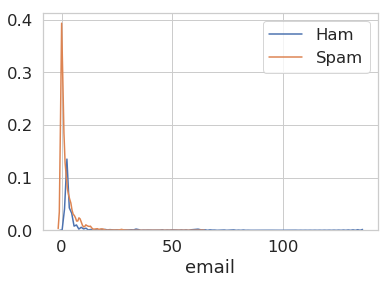

In [48]:
ham_at = train.loc[train['spam']==0, 'email'].str.replace('[^?]', '').str.len()
spam_at = train.loc[train['spam']==1, 'email'].str.replace('[^?]','').str.len()

sns.distplot(ham_at, hist=False, label='Ham')
sns.distplot(spam_at, hist=False, label='Spam')

#### 공백 문자 갯수

In [49]:
ham_space = train.loc[train['spam']==0, 'email'].str.replace('[^\s]', '').str.len()
spam_space = train.loc[train['spam']==1, 'email'].str.replace('[^\s]', '').str.len()

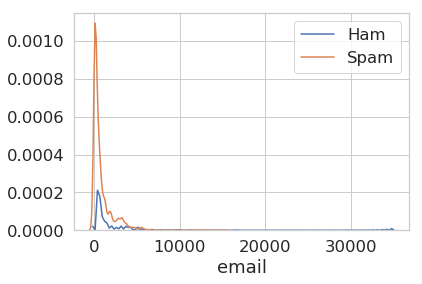

In [50]:
sns.distplot(ham_space, hist=False, label='Ham')
sns.distplot(spam_space, hist=False, label='Spam')

### 답메일 여부
- 제목에 reply:, Re:, re: 가 있는지 확인한다.

In [51]:
train[train.subject.str.contains('REPLY')] 

,id,subject,email,spam
5925,3798,Subject: URGENT REPLY.\n,mr.ronard tony\n wema bank plc. \n lagos/niger...,1


In [52]:
train[train.subject.str.contains('Reply')]

,id,subject,email,spam
522,1839,Subject: Immediate Reply Needed\n,"dear sir,\n \n i am dr james alabi, the chairm...",1


In [53]:
train[train.subject.str.contains('reply')]

,id,subject,email,spam
445,4857,Subject: Re: [ILUG] Mutt reply hooks\n,"on tue, jul 30, 2002 at 11:28:11am +0200, davi...",0
1856,268,Subject: Re: [ILUG] Mutt reply hooks\n,"hi,\n \n on tue, 30 jul 2002, gavin mccullagh ...",0
3155,214,Subject: Re: [ILUG] Mutt reply hooks\n,"on tue 30 jul 2002 10:28, david neary wrote:\n...",0
5992,4277,Subject: Re: [ILUG] Mutt reply hooks\n,"on tue, jul 30, 2002 at 11:28:11am +0200, davi...",0
6585,4858,Subject: Re: [ILUG] Mutt reply hooks\n,"hi,\n \n havn't tried this, but looks like wha...",0


In [54]:
print(len(train[train.subject.str.contains('re:')].loc[train['spam']==0]))
print(len(train[train.subject.str.contains('re:')].loc[train['spam']==1]))

10
14


In [55]:
print(len(train[train.subject.str.contains('Fw:')].loc[train['spam']==0]))
print(len(train[train.subject.str.contains('Fw:')].loc[train['spam']==1]))

8
25


In [56]:
print(len(train[train.subject.str.contains('Fwd')].loc[train['spam']==0]))
print(len(train[train.subject.str.contains('Fwd')].loc[train['spam']==1]))

21
3


In [57]:
train[train.subject.str.contains('fwd')]

,id,subject,email,spam
103,1583,Subject: Re: A moment of silence for the First...,bill stoddard wrote:\n \n >>gab> the problem i...,0
210,2157,Subject: Re: Re[4]: A moment of silence for th...,\n ----- original message -----\n from: <bitbi...,0
328,7237,Subject: RE: Re[2]: A moment of silence for th...,>\n > gab> the problem is that politics have g...,0
429,3289,Subject: A moment of silence for the First Ame...,http://www.post-gazette.com/columnists/2002090...,0
651,2177,Subject: Re: A moment of silence for the First...,> from: owen byrne <owen@permafrost.net>\n > a...,0
869,3611,Subject: Re[6]: A moment of silence for the Fi...,"hello bill,\n \n monday, september 30, 2002, 5...",0
889,4373,Subject: Re[2]: A moment of silence for the Fi...,>>\n >> http://www.post-gazette.com/columnists...,0
996,4712,Subject: [vox] Anarchist 'Scavenger Hunt' Rais...,\n \n anarchist 'scavenger hunt' raises d.c. p...,0
1060,4726,Subject: [vox] Anarchist 'Scavenger Hunt' Rais...,\n \n anarchist 'scavenger hunt' raises d.c. p...,0
1276,4897,Subject: Re[2]: A moment of silence for the Fi...,\n >>\n >>wishful thinking. people are just bi...,0


In [58]:
reply = ['reply', 'Re:', 'RE:', 'Fwd', 'fwd']   # 대체로 ham 메일에 많음.
reply = ['reply', 'Re:', 'RE:', 'Fwd', 'fwd']
ham_re = train[(train.subject.str.contains('|'.join(reply)))].loc[train['spam']==0]
spam_re = train[(train.subject.str.contains('|'.join(reply)))].loc[train['spam']==1]

redf = train[['spam']].copy()
redf['reply'] = train.subject.str.contains('|'.join(reply))

In [59]:
print(len(train))
print(len(ham_re))
print(len(spam_re))

7513
2835
87


In [60]:
redf.loc[redf['spam']==0, 'reply'].value_counts()

True     2835
False    2760
Name: reply, dtype: int64

In [61]:
redf.loc[redf['spam']==1, 'reply'].value_counts()

False    1831
True       87
Name: reply, dtype: int64

In [62]:
redf.loc[redf['reply']==False, 'spam'].value_counts()

0    2760
1    1831
Name: spam, dtype: int64

In [63]:
redf.loc[redf['reply']==True, 'spam'].value_counts()

0    2835
1      87
Name: spam, dtype: int64

### 메일 제목의 대문자 비율

#### (대문자) / (전체 문자)

In [64]:
ham_sub_capital = train.loc[train['spam']==0, 'subject'].str.replace('[^A-Z]', '').str.len() / train.loc[train['spam']==0, 'subject'].str.len()
spam_sub_capital = train.loc[train['spam']==1, 'subject'].str.replace('[^A-Z]', '').str.len() / train.loc[train['spam']==1, 'subject'].str.len()

/home/noparkee/anaconda3/envs/cose471/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/home/noparkee/anaconda3/envs/cose471/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


Text(0,0.5,'Ditribution')

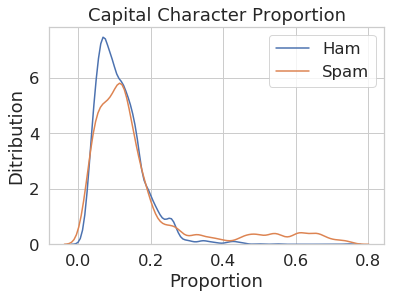

In [65]:
sns.distplot(ham_sub_capital, hist=False, label='Ham')
sns.distplot(spam_sub_capital, hist=False, label='Spam')

plt.title('Capital Character Proportion')
plt.xlabel('Proportion')
plt.ylabel('Ditribution')

#### (대문자) / (대문자 + 소문자)

In [66]:
ham_sub_capital2 = train.loc[train['spam']==0, 'subject'].str.replace('[^A-Z]', '').str.len() / train.loc[train['spam']==0, 'subject'].str.replace('[^a-zA-z]', '').str.len()
spam_sub_capital2 = train.loc[train['spam']==1, 'subject'].str.replace('[^A-Z]', '').str.len() / train.loc[train['spam']==1, 'subject'].str.replace('[^a-zA-z]', '').str.len()

/home/noparkee/anaconda3/envs/cose471/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/home/noparkee/anaconda3/envs/cose471/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


Text(0,0.5,'Ditribution')

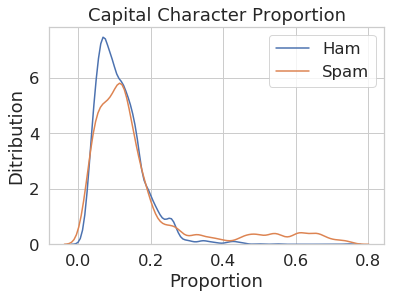

In [67]:
sns.distplot(ham_sub_capital, hist=False, label='Ham')
sns.distplot(spam_sub_capital, hist=False, label='Spam')

plt.title('Capital Character Proportion')
plt.xlabel('Proportion')
plt.ylabel('Ditribution')


### 대문자 갯수

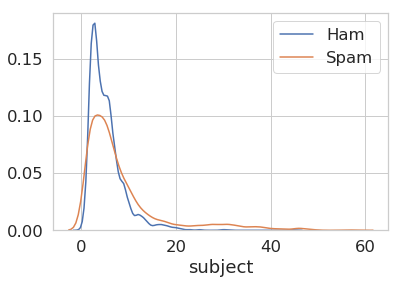

In [68]:
ham_sub_capital_num = train.loc[train['spam']==0, 'subject'].str.replace('[^A-Z]', '').str.len()
spam_sub_capital_num = train.loc[train['spam']==1, 'subject'].str.replace('[^A-Z]', '').str.len()

sns.distplot(ham_sub_capital_num, hist=False, label='Ham')
sns.distplot(spam_sub_capital_num, hist=False, label='Spam')

### 줄바꿈 문자 (\n) 갯수

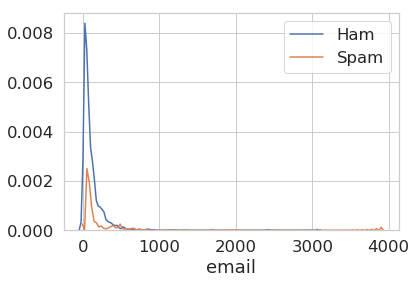

In [69]:
ham_enter = train.loc[train['spam']==1, 'email'].str.count('\n')
spam_enter = train.loc[train['spam']==0, 'email'].str.count('\n')
sns.distplot(ham_enter, hist=False, label='Ham')
sns.distplot(spam_enter, hist=False, label='Spam')

### 알파벳 

#### 제목

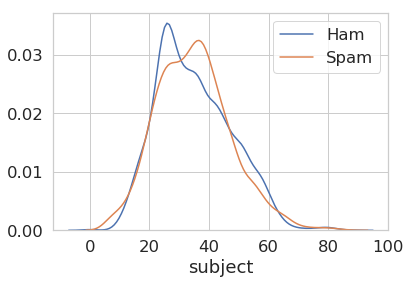

In [70]:
ham_alpha_num = train.loc[train['spam']==0, 'subject'].str.replace('[^a-zA-Z]', '').str.len()
spam_alpha_num = train.loc[train['spam']==1, 'subject'].str.replace('[^a-zA-Z]', '').str.len()

sns.distplot(ham_alpha_num, hist=False, label='Ham')
sns.distplot(spam_alpha_num, hist=False, label='Spam')

/home/noparkee/anaconda3/envs/cose471/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/home/noparkee/anaconda3/envs/cose471/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


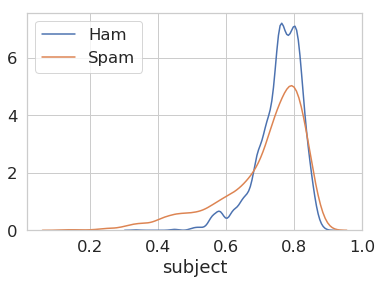

In [71]:
ham_alpha_pro = train.loc[train['spam']==0, 'subject'].str.replace('[^a-zA-Z]', '').str.len() / train.loc[train['spam']==0, 'subject'].str.len()
spam_alpha_pro = train.loc[train['spam']==1, 'subject'].str.replace('[^a-zA-Z]', '').str.len() / train.loc[train['spam']==1, 'subject'].str.len()

sns.distplot(ham_alpha_pro, hist=False, label='Ham')
sns.distplot(spam_alpha_pro, hist=False, label='Spam')

#### 본문

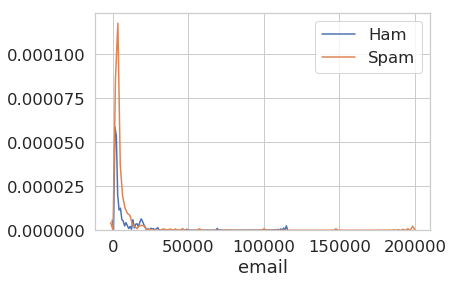

In [72]:
ham_alpha_num = train.loc[train['spam']==0, 'email'].str.replace('[^a-zA-Z]', '').str.len()
spam_alpha_num = train.loc[train['spam']==1, 'email'].str.replace('[^a-zA-Z]', '').str.len()

sns.distplot(ham_alpha_num, hist=False, label='Ham')
sns.distplot(spam_alpha_num, hist=False, label='Spam')

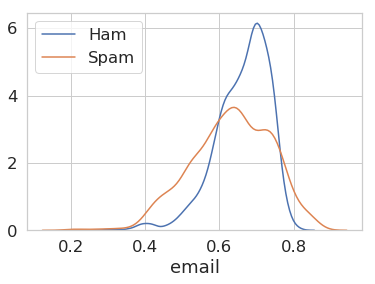

In [73]:
ham_alpha_pro = train.loc[train['spam']==0, 'email'].str.replace('[^a-zA-Z]', '').str.len() / train.loc[train['spam']==0, 'email'].str.len()
spam_alpha_pro = train.loc[train['spam']==1, 'email'].str.replace('[^a-zA-Z]', '').str.len() / train.loc[train['spam']==1, 'email'].str.len()

sns.distplot(ham_alpha_pro, hist=False, label='Ham')
sns.distplot(spam_alpha_pro, hist=False, label='Spam')

### 알파벳 + 숫자

#### 제목

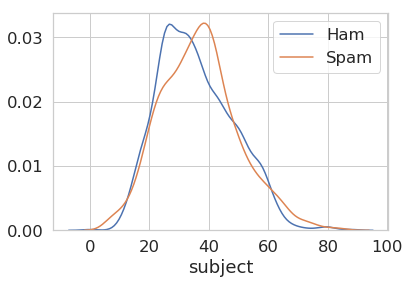

In [74]:
ham_alphad_num = train.loc[train['spam']==0, 'subject'].str.replace('[^a-zA-Z0-9]', '').str.len()
spam_alphad_num = train.loc[train['spam']==1, 'subject'].str.replace('[^a-zA-Z0-9]', '').str.len()

sns.distplot(ham_alphad_num, hist=False, label='Ham')
sns.distplot(spam_alphad_num, hist=False, label='Spam')

/home/noparkee/anaconda3/envs/cose471/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/home/noparkee/anaconda3/envs/cose471/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


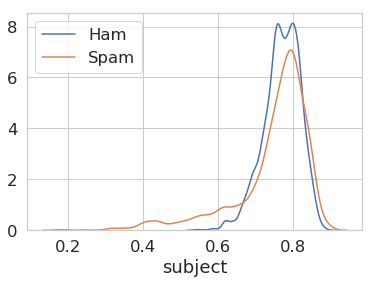

In [75]:
ham_alphad_pro = train.loc[train['spam']==0, 'subject'].str.replace('[^a-zA-Z0-9]', '').str.len() / train.loc[train['spam']==0, 'subject'].str.len()
spam_alphad_pro = train.loc[train['spam']==1, 'subject'].str.replace('[^a-zA-Z0-9]', '').str.len() / train.loc[train['spam']==1, 'subject'].str.len()

sns.distplot(ham_alphad_pro, hist=False, label='Ham')
sns.distplot(spam_alphad_pro, hist=False, label='Spam')

#### 본문

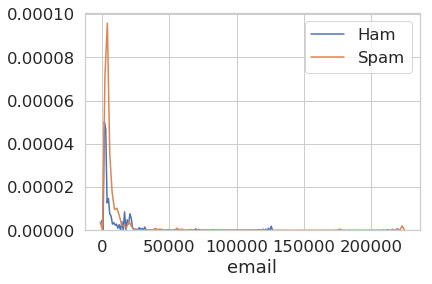

In [76]:
ham_alphad_num = train.loc[train['spam']==0, 'email'].str.replace('[^a-zA-Z0-9]', '').str.len()
spam_alphad_num = train.loc[train['spam']==1, 'email'].str.replace('[^a-zA-Z0-9]', '').str.len()

sns.distplot(ham_alphad_num, hist=False, label='Ham')
sns.distplot(spam_alphad_num, hist=False, label='Spam')

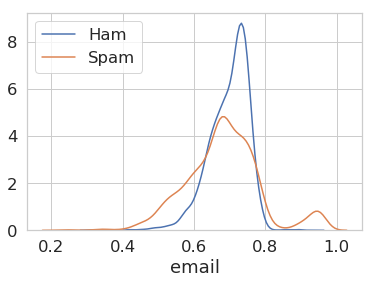

In [77]:
ham_alphad_pro = train.loc[train['spam']==0, 'email'].str.replace('[^a-zA-Z0-9]', '').str.len() / train.loc[train['spam']==0, 'email'].str.len()
spam_alphad_pro = train.loc[train['spam']==1, 'email'].str.replace('[^a-zA-Z0-9]', '').str.len() / train.loc[train['spam']==1, 'email'].str.len()

sns.distplot(ham_alphad_pro, hist=False, label='Ham')
sns.distplot(spam_alphad_pro, hist=False, label='Spam')

### 숫자

#### 제목

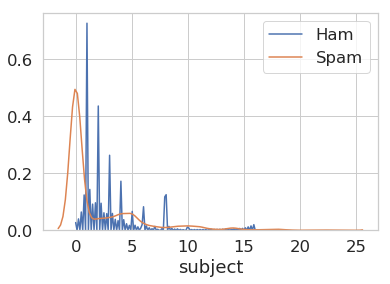

In [78]:
ham_dec_num = train.loc[train['spam']==0, 'subject'].str.replace('[\D]', '').str.len()
spam_dec_num = train.loc[train['spam']==1, 'subject'].str.replace('[\D]', '').str.len()

sns.distplot(ham_dec_num, hist=False, label='Ham')
sns.distplot(spam_dec_num, hist=False, label='Spam')

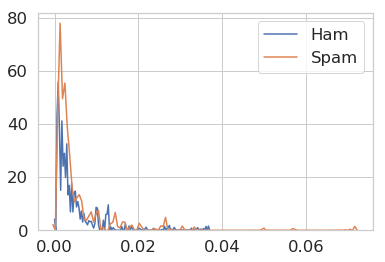

In [79]:
ham_dec_pro = train.loc[train['spam']==0, 'subject'].str.replace('[\D]', '').str.len() / train.loc[train['spam']==0, 'email'].str.len()
spam_dec_pro = train.loc[train['spam']==1, 'subject'].str.replace('[\D]', '').str.len() / train.loc[train['spam']==1, 'email'].str.len()

sns.distplot(ham_dec_pro, hist=False, label='Ham')
sns.distplot(spam_dec_pro, hist=False, label='Spam')

#### 본문

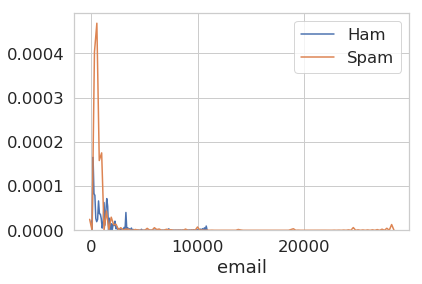

In [80]:
ham_dec_num = train.loc[train['spam']==0, 'email'].str.replace('[\D]', '').str.len()
spam_dec_num = train.loc[train['spam']==1, 'email'].str.replace('[\D]', '').str.len()

sns.distplot(ham_dec_num, hist=False, label='Ham')
sns.distplot(spam_dec_num, hist=False, label='Spam')

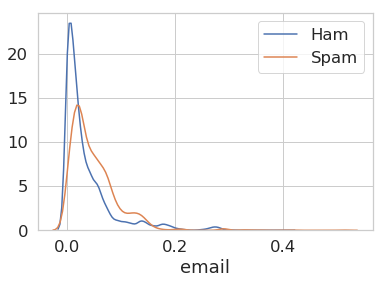

In [81]:
ham_dec_pro = train.loc[train['spam']==0, 'email'].str.replace('[\D]', '').str.len() / train.loc[train['spam']==0, 'email'].str.len()
spam_dec_pro = train.loc[train['spam']==1, 'email'].str.replace('[\D]', '').str.len() / train.loc[train['spam']==1, 'email'].str.len()

sns.distplot(ham_dec_pro, hist=False, label='Ham')
sns.distplot(spam_dec_pro, hist=False, label='Spam')

### 자주 나오는 단어

#### 알파벳에 대해서만

In [82]:
ham_asdf = train.loc[train['spam']==0, 'email'].str.replace('[^a-zA-Z]', ' ').map(remove_stopwords)
spam_asdf = train.loc[train['spam']==1, 'email'].str.replace('[^a-zA-Z]', ' ').map(remove_stopwords)

print(ham_asdf.head())
print(spam_asdf.head())

0    [playing, past, issues, annoyed, easy, way, ma...
1    [url, http, diveintomark, org, archives, html,...
2    [please, post, link, fox, original, message, a...
3    [article, nytimes, com, sent, khare, alumni, c...
4    [html, head, title, tech, update, today, title...
Name: email, dtype: object
5     [secatt, fuklemuttfusq, content, type, text, p...
13    [free, adult, lifetime, membership, limited, t...
15    [table, width, border, align, center, borderco...
18    [html, head, head, body, center, table, border...
19    [html, head, head, center, h, b, font, face, a...
Name: email, dtype: object


In [83]:
hamwhole = ' '.join(ham_asdf.str.join(' '))
spamwhole = ' '.join(spam_asdf.str.join(' '))

hamwhole_lst = hamwhole.split(' ')
spamwhole_lst = spamwhole.split(' ')

hamwhole_set = list(set(hamwhole_lst))
spamwhole_set = list(set(spamwhole_lst))

In [84]:
hamdict = {}
hambow = []
for w in hamwhole_lst:
    if w not in hamdict.keys():
        hamdict[w] = len(hamdict)
        hambow.insert(len(hamdict)-1, 1)
    else:
        idx = hamdict.get(w)
        hambow[idx] += 1
        
spamdict = {}
spambow = []
for w in spamwhole_lst:
    if w not in spamdict.keys():
        spamdict[w] = len(spamdict)
        spambow.insert(len(spamdict)-1, 1)
    else:
        idx = spamdict.get(w)
        spambow[idx] += 1

In [85]:
def get_list(num):
    lstttt = list(np.argsort(hambow)[-num:])
    hamdict_key_lst = list(hamdict.keys())
    hamkey = []
    for i in lstttt:
        if len(hamdict_key_lst[i]) > 1:
            hamkey.append(hamdict_key_lst[i])

    lstttt2 = list(np.argsort(spambow)[-num:])
    spamdict_key_lst = list(spamdict.keys())
    spamkey = []
    for i in lstttt2:
        if len(spamdict_key_lst[i]) > 1:
            spamkey.append(spamdict_key_lst[i])
    
    return hamkey, spamkey

In [86]:
moreham, morespam = get_list(15)

In [87]:
morespam

['nbsp', 'http', 'color', 'face', 'width', 'tr', 'size', 'br', 'td', 'font']

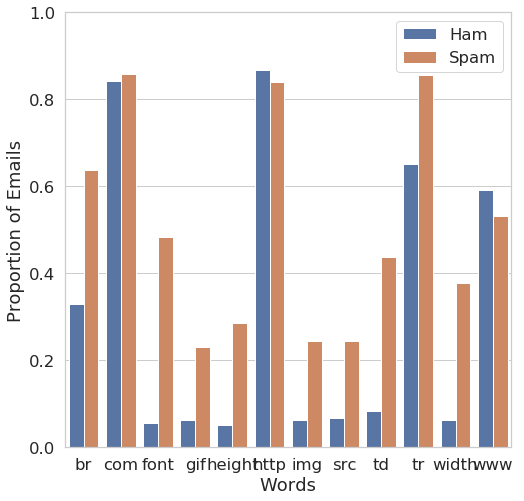

In [88]:
morehamtest = words_in_texts(moreham, train['email'])

df = pd.DataFrame(data = morehamtest, columns = moreham)
df['label'] = train['spam']
plt.figure(figsize=(8,8))
sns.barplot(x = "variable", 
            y = "value", 
            hue = "label", 
            data = (df
                    .replace({'label': 
                                {0 : 'Ham', 
                                 1 : 'Spam'}})
                    .melt('label')
                    .groupby(['label', 'variable'])
                    .mean()
                    .reset_index()))

plt.ylim([0, 1])
plt.xlabel('Words')
plt.ylabel('Proportion of Emails')
plt.legend(title = "")
plt.show()

# font, gif, height, img, src, td, width

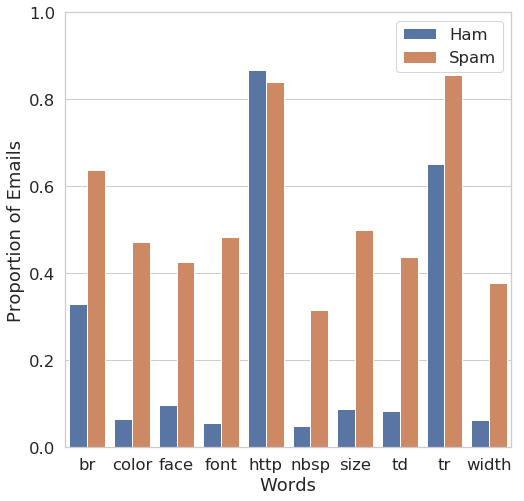

In [89]:
morespamtest = words_in_texts(morespam, train['email'])

df = pd.DataFrame(data = morespamtest, columns = morespam)
df['label'] = train['spam']
plt.figure(figsize=(8,8))
sns.barplot(x = "variable", 
            y = "value", 
            hue = "label", 
            data = (df
                    .replace({'label': 
                                {0 : 'Ham', 
                                 1 : 'Spam'}})
                    .melt('label')
                    .groupby(['label', 'variable'])
                    .mean()
                    .reset_index()))

plt.ylim([0, 1])
plt.xlabel('Words')
plt.ylabel('Proportion of Emails')
plt.legend(title = "")
plt.show()

# color, face, font, nbsp, size, td, width

두 개의 그래프 결과 font, gif, height, img, src, td, width, color, face, nbsp, size가 spam에서 더 자주 등장한다.

#### 모든 문자에 대해서

In [90]:
hamwhole_all = ' '.join(train.loc[train['spam']==0, 'email'])
spamwhole_all = ' '.join(train.loc[train['spam']==1, 'email'])

hamwhole_lst_all = hamwhole_all.split(' ')
spamwhole_lst_all = spamwhole_all.split(' ')

hamwhole_set_all = list(set(hamwhole_lst_all))
spamwhole_set_all = list(set(spamwhole_lst_all))

In [91]:
hamdict_all = {}
hambow_all = []
for w in hamwhole_lst_all:
    if w not in hamdict_all.keys():
        hamdict_all[w] = len(hamdict_all)
        hambow_all.insert(len(hamdict_all)-1, 1)
    else:
        idx = hamdict_all.get(w)
        hambow_all[idx] += 1
        
spamdict_all = {}
spambow_all = []
for w in spamwhole_lst_all:
    if w not in spamdict_all.keys():
        spamdict_all[w] = len(spamdict_all)
        spambow_all.insert(len(spamdict_all)-1, 1)
    else:
        idx = spamdict_all.get(w)
        spambow_all[idx] += 1

In [92]:
def get_list(num):
    lstttt = list(np.argsort(hambow_all)[-num:])
    hamdict_key_lst = list(hamdict.keys())
    hamkey = []
    for i in lstttt:
        if len(hamdict_key_lst[i]) > 1:
            hamkey.append(hamdict_key_lst[i])

    lstttt2 = list(np.argsort(spambow_all)[-num:])
    spamdict_key_lst = list(spamdict.keys())
    spamkey = []
    for i in lstttt2:
        if len(spamdict_key_lst[i]) > 1:
            spamkey.append(spamdict_key_lst[i])
    
    return hamkey, spamkey

In [93]:
moreham_all, morespam_all = get_list(15)

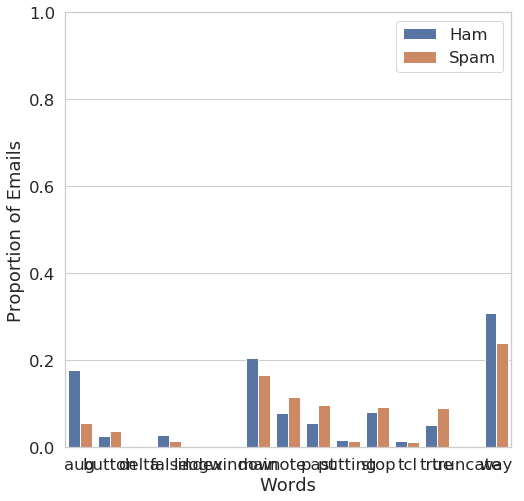

In [94]:
morehamtest_all = words_in_texts(moreham_all, train['email'])

df = pd.DataFrame(data = morehamtest_all, columns = moreham_all)
df['label'] = train['spam']
plt.figure(figsize=(8,8))
sns.barplot(x = "variable", 
            y = "value", 
            hue = "label", 
            data = (df
                    .replace({'label': 
                                {0 : 'Ham', 
                                 1 : 'Spam'}})
                    .melt('label')
                    .groupby(['label', 'variable'])
                    .mean()
                    .reset_index()))

plt.ylim([0, 1])
plt.xlabel('Words')
plt.ylabel('Proportion of Emails')
plt.legend(title = "")
plt.show()

In [95]:
sorted(df.columns)[0]

'aug'

'aug'라는 단어가 ham메일에서 자주 등장한다

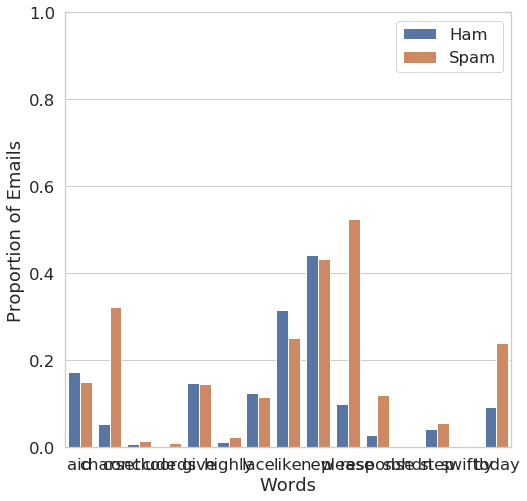

In [96]:
morespamtest_all = words_in_texts(morespam_all, train['email'])

df = pd.DataFrame(data = morespamtest_all, columns = morespam_all)
df['label'] = train['spam']
plt.figure(figsize=(8,8))
sns.barplot(x = "variable", 
            y = "value", 
            hue = "label", 
            data = (df
                    .replace({'label': 
                                {0 : 'Ham', 
                                 1 : 'Spam'}})
                    .melt('label')
                    .groupby(['label', 'variable'])
                    .mean()
                    .reset_index()))

plt.ylim([0, 1])
plt.xlabel('Words')
plt.ylabel('Proportion of Emails')
plt.legend(title = "")
plt.show()

In [97]:
[sorted(df.columns)[1]] + [sorted(df.columns)[9]] + [sorted(df.columns)[10]] + [sorted(df.columns)[14]]

['charset', 'new', 'please', 'swiftly']

charset, new, please, swiftly 단어가 spam메일에서 더 자주 등장한다.

<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />


### Question 7: EDA

In the cell below, show a visualization that you used to select features for your model. Include both

1. A plot showing something meaningful about the data that helped you during feature / model selection.
2. 2-3 sentences describing what you plotted and what its implications are for your features.

Feel free to create as many plots as you want in your process of feature selection, but select one for the response cell below.

**You should not just produce an identical visualization to question 3.** Specifically, don't show us a bar chart of proportions, or a one-dimensional class-conditional density plot. Any other plot is acceptable, as long as it comes with thoughtful commentary. Here are some ideas:

1. Consider the correlation between multiple features (look up correlation plots and `sns.heatmap`). 
1. Try to show redundancy in a group of features (e.g. `body` and `html` might co-occur relatively frequently, or you might be able to design a feature that captures all html tags and compare it to these). 
1. Visualize which words have high or low values for some useful statistic.
1. Visually depict whether spam emails tend to be wordier (in some sense) than ham emails.

Generate your visualization in the cell below and provide your description in a comment.

<!--
BEGIN QUESTION
name: q8
manual: True
format: image
points: 6
-->
<!-- EXPORT TO PDF format:image -->

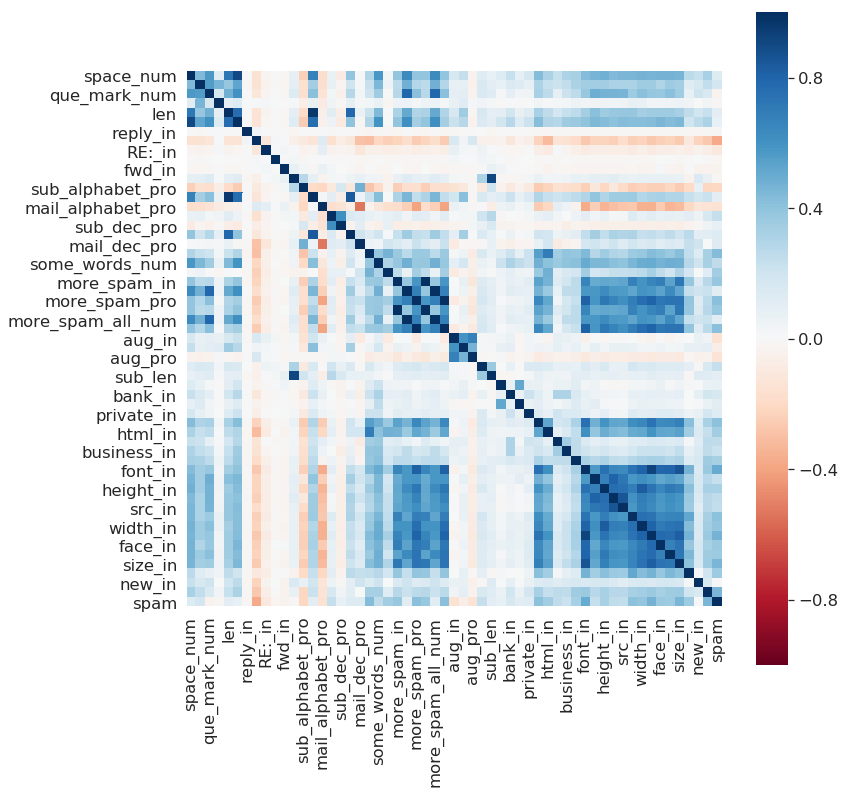

In [98]:
# Write your description (2-3 sentences) as a comment here:
# feature와 feature, feature와 spam 여부간의 상관관계를 알기 위해, correlation heatmap을 그렸다.
# 그린 heatmap에서는 색이 진할수록 상관계수가 크고, 색이 흰색에 가까울수록 상관계수가 작은 것인데, a와 b의 상관계수가 크다는 것은
# a라는 것이 변하면 b라는 것도 변한다는 의미이다. x축의 spam을 기준으로 y축의 feature들과 비교해보면 (아래의 correlation heatmap은 대칭이다.)
# font라는 단어가 email에 들어있는지 여부를 의미하는 font_in feature가 가장 진하고 이는 spam 여부와 가장 큰 상관관계가 있다고 해석할 수 있다.
# 이런식으로 feature와 spam의 상관관계를 해석할 수 있고, 이를 통해 spam과의 상관계수가 작은 feature는 지울 수도 있다.

# Write the code to generate your visualization here:
def inword(train, word):
    sr = train.str.contains(word).astype(int)
    return sr
def numword(train, word):
    sr = train.str.count(word)
    return sr
    
def make_feature(train):
    trainR = train.fillna('')
    
    email_len = trainR['email'].str.len()
    email_word_num = trainR['email'].str.split().str.len()
    
    # 공백 문자와 문장 부호 갯수
    trainX = pd.DataFrame({'space_num': trainR['email'].str.replace('[^\s]', '').str.len()})
    trainX['exc_mark_num'] = trainR['email'].str.replace('[^!]', '').str.len()
    trainX['que_mark_num'] = trainR['email'].str.replace('[^?]', '').str.len()
    trainX['at_mark_num'] = trainR['email'].str.replace('[^@]', '').str.len()
       
    trainX['len'] = trainR['email'].str.len()
    trainX['word_num'] = trainR['email'].map(remove_stopwords).str.len()
    
    reply = ['reply', 'Re:', 'RE:']   # 대체로 ham 메일에 많음.
    forward = ['Fwd', 'fwd']
    #trainX['reply'] = trainR['subject'].str.contains('|'.join(reply)).astype(int)
    #reply2 = ['Fw', 'REPLY', 'Reply']   # 대체로 spam 메일에 많음 (Fw말고는 좀 위험)
    #trainX['reply2'] = trainR['subject'].str.contains('|'.join(reply2)).astype(int)
    for w in reply:
        trainX[w+'_in'] = inword(trainR['subject'], w)
    for w in forward:
        trainX[w+'_in'] = inword(trainR['subject'], w)
    
    # trainX['Fw_in'] = trainR['subject'].str.contains('Fw').astype(int)
    
    trainX['sub_alphabet_num'] = trainR['subject'].str.replace('[^a-zA-Z]', '').str.len()
    trainX['sub_alphabet_pro'] = trainR['subject'].str.replace('[^a-zA-Z]', '').str.len() / email_len
    
    trainX['mail_alphabet_num'] = trainR['email'].str.replace('[^a-zA-Z]', '').str.len()
    trainX['mail_alphabet_pro'] = trainR['email'].str.replace('[^a-zA-Z]', '').str.len() / email_len
    
    trainX['sub_dec_num'] = trainR['subject'].str.replace('[^0-9]', '').str.len()
    trainX['sub_dec_pro'] = trainR['subject'].str.replace('[^0-9]', '').str.len() / email_len
    
    trainX['mail_dec_num'] = trainR['email'].str.replace('[^0-9]', '').str.len()
    trainX['mail_dec_pro'] = trainR['email'].str.replace('[^0-9]', '').str.len() / email_len  
    
    
    some_words = ['drug', 'bank', 'prescription', 'private', 'body', 'html', 'money', 'business', 'offer']
    trainX['some_words_in'] = trainR['email'].str.contains('|'.join(some_words)).astype(int)
    trainX['some_words_num'] = trainR['email'].str.count('|'.join(some_words))
    trainX['some_words_pro'] = trainR['email'].str.count('|'.join(some_words)) / email_word_num
    
    more_spam_words = ['font', 'gif', 'height', 'img', 'src', 'td', 'width', 'color', 'face', 'nbsp', 'size']
    trainX['more_spam_in'] = trainR['email'].str.contains('|'.join(more_spam_words)).astype(int)
    trainX['more_spam_num'] = trainR['email'].str.count('|'.join(more_spam_words))
    trainX['more_spam_pro'] = trainR['email'].str.count('|'.join(more_spam_words)) / email_word_num
    
    more_spam_words_all = ['charset', 'new', 'please']
    trainX['more_spam_all_in'] = trainR['email'].str.contains('|'.join(more_spam_words)).astype(int)
    trainX['more_spam_all_num'] = trainR['email'].str.count('|'.join(more_spam_words))
    trainX['more_spam_all_pro'] = trainR['email'].str.count('|'.join(more_spam_words)) / email_word_num
    
    # ham에서 더 자주 등장
    trainX['aug_in'] = trainR['email'].str.contains('aug').astype(int) 
    trainX['aug_num'] = trainR['email'].str.count('aug')
    trainX['aug_pro'] = trainR['email'].str.count('aug') / email_word_num
    
    trainX['sub_cap'] = trainR['subject'].str.replace('[^A-Z]', '').str.len()
    trainX['sub_len'] = trainR['subject'].str.len()
    
    for w in some_words:
        trainX[w+'_in'] = inword(trainR['email'], w)
    for w in more_spam_words:
        trainX[w+'_in'] = inword(trainR['email'], w)
    for w in more_spam_words_all:
        trainX[w+'_in'] = inword(trainR['email'], w)

    
    
    return trainX



# plot
train_X = make_feature(train)
withSpam = train_X.copy()
withSpam['spam'] = train['spam']

plt.figure(figsize=(12,12))
sns.heatmap(withSpam.corr(), vmin=-1, vmax=1, cmap='RdBu', square=True)   # coolwarm / RdBu

In [99]:
withSpam.corr()['spam'].sort_values(ascending=False)

spam                 1.000000
font_in              0.501390
color_in             0.475090
please_in            0.457841
size_in              0.454826
some_words_in        0.437353
more_spam_pro        0.419287
more_spam_all_pro    0.419287
body_in              0.413749
td_in                0.406786
width_in             0.393544
more_spam_all_in     0.375517
more_spam_in         0.375517
face_in              0.373130
charset_in           0.360561
nbsp_in              0.360323
html_in              0.349627
some_words_pro       0.345416
offer_in             0.330709
height_in            0.327562
some_words_num       0.256690
img_in               0.256527
money_in             0.250248
src_in               0.245901
sub_cap              0.238998
gif_in               0.236619
sub_dec_num          0.234521
business_in          0.220087
exc_mark_num         0.185527
bank_in              0.168152
space_num            0.133666
mail_dec_num         0.133621
mail_dec_pro         0.126432
private_in

<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />


### Question 8: Precision-Recall Curve

We can trade off between precision and recall. In most cases we won't be able to get both perfect precision (i.e. no false positives) and recall (i.e. no false negatives), so we have to compromise.

Recall that logistic regression calculates the probability that an example belongs to a certain class. 
* Then, to classify an example we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. 
* However, *we can adjust that cutoff*: we can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam. 

This is how we can trade off false positives and false negatives.

The precision-recall curve shows this trade off for each possible cutoff probability. In the cell below, [plot a precision-recall curve](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#plot-the-precision-recall-curve) for your final classifier.

<!--
BEGIN QUESTION
name: q9
manual: True
points: 3
-->
<!-- EXPORT TO PDF -->

(0, 1)

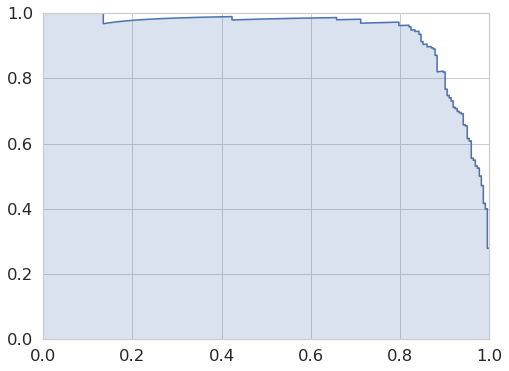

In [100]:
from sklearn.metrics import precision_recall_curve

# Note that you'll want to use the .predict_proba(...) method for your classifier
# instead of .predict(...) so you get probabilities, not classes

# BEGIN YOUR CODE
# -----------------------

train_acc = []
val_acc = []
fs = withSpam.corr()['spam'].sort_values(ascending = False)

corr = np.arange(0, 0.4, 0.005)

train_X = make_feature(train)   # make_feature는 Question 7에서 정의함.
val_X = make_feature(val)   # validation set도 train set과 형태 맞춰주기

# 상관계수 기준 중 어떤 상관계수가 validation set에 대해 결과가 잘 나오는지 체크하기 위해
for c in corr:
        
    selected = fs[(abs(fs)>c) & (abs(fs) != 1)].index

    my_model = LogisticRegression().fit(train_X[selected], train['spam'])
    #my_model_training_accuracy = my_model.score(train_X[selected], train['spam'])
    
    train_acc.append(my_model.score(train_X[selected], train['spam']))
    val_acc.append(my_model.score(val_X[selected], val['spam']))
         
#print(train_acc)
#print(val_acc)

# validation set에 대해 가장 좋은 성능을 보였던 상관계수 기준 설정
max_c = corr[np.argmax(val_acc)]
final_selected = fs[(abs(fs)>max_c) & (abs(fs) != 1)].index

final_model = LogisticRegression().fit(train_X[final_selected], train['spam'])
#print(train_acc[np.argmax(val_acc)])
#print(val_acc[np.argmax(val_acc)])
                     
plt.figure(figsize=(8,6))
precision, recall, threshold = precision_recall_curve(val['spam'], final_model.predict_proba(val_X[final_selected])[:, 1]) 
plt.plot(recall, precision)
plt.fill_between(recall, precision, alpha=0.2, color='b')
plt.xlim((0, 1))
plt.ylim((0, 1))

#print(final_model.score(train_X[final_selected], train['spam']))
#print(final_model.score(val_X[final_selected], val['spam']))

# -----------------------
# END YOUR CODE

<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />


## Question 9: Submitting to Kaggle

The following code will write your predictions on the test dataset to a CSV, which you can submit to Kaggle. You may need to modify it to suit your needs.

Save your predictions in a 1-dimensional array called `test_predictions`. *Even if you are not submitting to Kaggle, please make sure you've saved your predictions to `test_predictions` as this is how your score for this question will be determined.*

Remember that if you've performed transformations or featurization on the training data, you must also perform the same transformations on the test data in order to make predictions. For example, if you've created features for the words "drug" and "money" on the training data, you must also extract the same features in order to use scikit-learn's `.predict(...)` method.

You should submit your CSV files to https://www.kaggle.com/c/cose471sp21project1

*The provided tests check that your predictions are in the correct format, but you must submit to Kaggle to evaluate your classifier accuracy.*

<!--
BEGIN QUESTION
name: q10
points: 15
-->

In [101]:
# BEGIN YOUR CODE
# -----------------------
test_predictions = final_model.predict(make_feature(test)[final_selected])
# -----------------------
# END YOUR CODE

In [102]:
ok.grade("q9");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



In [103]:
from datetime import datetime

# Assuming that your predictions on the test set are stored in a 1-dimensional array called
# test_predictions. Feel free to modify this cell as long you create a CSV in the right format.

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.isoformat(datetime.now()).split(".")[0]
submission_df.to_csv("submission_{}.csv".format(timestamp), index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
print('You may now upload this CSV file to Kaggle for scoring.')

# 제출 파일: submission_2021-05-21T20:32:16.csv

Created a CSV file: submission_2021-05-21T20:32:16.csv.
You may now upload this CSV file to Kaggle for scoring.


<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />


## Question 10: Attach Your Leaderboard Screenshot


Take a screenshot of your submission to Kaggle as follows. This screenshot should contain your testing score. 

**You should replace `images/leaderboard_example.png` with your screenshot!**

Note that, in order to get full credit on the accuracy part of this assignment, you must get at least **88%** accuracy on the test set. 

<br/><br/>

![](./images/score.png)

이 코드로 만든 csv 파일은 0.92200인데, 캐글에서 final score를 0.92200으로 선택에도 저렇게 떠서 제 final score인 0.92200도 나오도록 캡쳐했습니다. (0.92400는 이전 코드인데, 그 코드를 잘못지워서 새로 제출했습니다.)

<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

### Congratulations! You have completed Project 1.

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output.,

**Please save before submitting!**

Please generate pdf as follows and submit it to Gradescope.

**File > Print Preview > Print > Save as pdf**

<!-- EXPECT 9 EXPORTED QUESTIONS -->